In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.set_option("display.max_columns", 100)

## 0. Data Preparation

In [3]:
## READ DATASET

default = pd.read_csv("../datasets/input/UCI_Credit_Card.csv", index_col="ID")
default.rename(columns= lambda x: x.lower(), inplace=True)

# Base values : female, other_education, not_married
default['grad_school'] = (default['education'] == 1).astype('int')
default['university'] = (default['education'] == 2).astype('int')
default['high_school'] = (default['education'] == 3).astype('int')

default['male'] = (default['sex']==1).astype(int)
default['married'] = (default['marriage']==1).astype(int)

# for pay features if <=0 then  it means it was not delayed

pay_features = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
for p in pay_features:
    default.loc[default[p] <=0, p] = 0

default.rename(columns = {'default.payment.next.month': "default"}, inplace=True)


default.drop(['education', 'sex', 'marriage'], axis=1, inplace=True)



## Building models using all features

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler

In [6]:
target_name = 'default'
X = default.drop('default', axis=1)
robust_scaler = RobustScaler()
X = robust_scaler.fit_transform(X)
y = default[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123, stratify=y)

In [7]:
def CMatrix(CM, labels=['pay', 'default']):
    df = pd.DataFrame(data=CM, index=labels, columns=labels)
    df.index.name= 'TRUE'
    df.columns.name = 'PREDICTION'
    df.loc['Total'] = df.sum()
    df['Total']= df.sum(axis=1)
    return df

## Preparing a Dataframe for model Analysis

In [24]:
# Dataframe for evaluation metrics
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall'], 
                       columns=['NULL', 'LogisticReg', 'ClassTree', 'NaiveBayes'])

### Which metric should I  use ??
#### **. False Positive**: A person who will pay predicted as defaulter 
#### **. False Negative**: A person who will default predicted as payer

### The NULL model: always predict the most common category

In [26]:
y_pred_test = np.repeat(y_train.value_counts().idxmax(), y_test.size)
metrics.loc['accuracy', 'NULL'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision', 'NULL'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall', 'NULL'] = recall_score(y_pred= y_pred_test, y_true= y_test)

CM = confusion_matrix(y_pred= y_pred_test, y_true = y_test)
CMatrix(CM=CM)

/home/harendra/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PREDICTION,pay,default,Total
TRUE,,,
pay,3505,0,3505
default,995,0,995
Total,4500,0,4500


### A. Logistic Regression

In [27]:
# 1. import the estimator object (models)
from sklearn.linear_model import LogisticRegression

# 2. Create an instance of an estimator
logistic_reg = LogisticRegression(n_jobs=-1, random_state=15)

# 3. Use the train data to train an estimator
logistic_reg.fit(X_train, y_train)

# 4. Evaluate the model
y_pred_test= logistic_reg.predict(X_test)
metrics.loc['accuracy', 'LogisticReg'] = accuracy_score(y_true=y_test, y_pred= y_pred_test)
metrics.loc['precision', 'LogisticReg'] = precision_score(y_true=y_test, y_pred= y_pred_test)
metrics.loc['recall', 'LogisticReg'] = recall_score(y_true=y_test, y_pred= y_pred_test)

# Confusion Matrix
CM = confusion_matrix(y_pred= y_pred_test, y_true = y_test)
CMatrix(CM=CM)




PREDICTION,pay,default,Total
TRUE,,,
pay,3365,140,3505
default,671,324,995
Total,4036,464,4500


## B. Decision Trees

In [28]:
# 1. import the estimator object(models)
from sklearn.tree import DecisionTreeClassifier

# 2. Create an instance of an estimator
class_tree = DecisionTreeClassifier(min_samples_split=30, min_samples_leaf=10, random_state=10)

# 3. Use the train data to train an estimator
class_tree.fit(X_train, y_train)

# 4. Evaluate the model
y_pred_test= class_tree.predict(X_test)
metrics.loc['accuracy', 'ClassTree'] = accuracy_score(y_true=y_test, y_pred= y_pred_test)
metrics.loc['precision', 'ClassTree'] = precision_score(y_true=y_test, y_pred= y_pred_test)
metrics.loc['recall', 'ClassTree'] = recall_score(y_true=y_test, y_pred= y_pred_test)

# Confusion Matrix
CM = confusion_matrix(y_pred= y_pred_test, y_true = y_test)
CMatrix(CM=CM)


PREDICTION,pay,default,Total
TRUE,,,
pay,3185,320,3505
default,634,361,995
Total,3819,681,4500


## C. Naive Bayes Classifier

In [32]:
# 1. import the estimator object(models)
from sklearn.naive_bayes import GaussianNB

# 2. Create an instance of an estimator
NBC = GaussianNB()

# 3. Use the train data to train an estimator
NBC.fit(X_train, y_train)

# 4. Evaluate the model
y_pred_test= NBC.predict(X_test)
metrics.loc['accuracy', 'NaiveBayes'] = accuracy_score(y_true=y_test, y_pred= y_pred_test)
metrics.loc['precision', 'NaiveBayes'] = precision_score(y_true=y_test, y_pred= y_pred_test)
metrics.loc['recall', 'NaiveBayes'] = recall_score(y_true=y_test, y_pred= y_pred_test)

# Confusion Matrix
CM = confusion_matrix(y_pred= y_pred_test, y_true = y_test)
CMatrix(CM=CM)

PREDICTION,pay,default,Total
TRUE,,,
pay,2912,593,3505
default,439,556,995
Total,3351,1149,4500


In [33]:
100*metrics

,NULL,LogisticReg,ClassTree,NaiveBayes
accuracy,77.888889,81.977778,78.8,77.066667
precision,0.0,69.827586,53.010279,48.389904
recall,0.0,32.562814,36.281407,55.879397


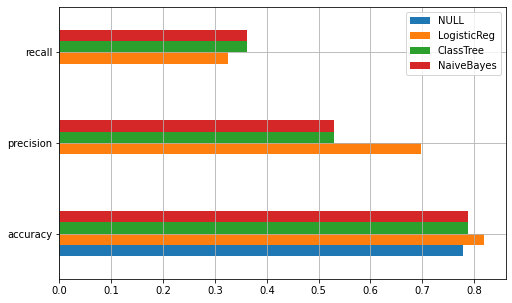

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))
metrics.plot(kind='barh', ax=ax)
ax.grid();

In [34]:
precision_nb, recall_nb, thresholds_nb = precision_recall_curve(y_true= y_test, 
                                                               probas_pred=NBC.predict_proba(X_test)[:, 1])
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_true= y_test,
                                                               probas_pred=logistic_reg.predict_proba(X_test)[:, 1])

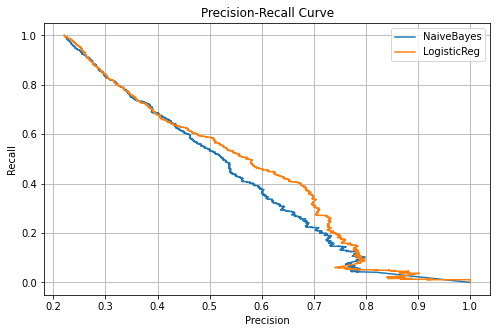

In [35]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(precision_nb, recall_nb, label='NaiveBayes')
ax.plot(precision_lr, recall_lr, label='LogisticReg')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curve')
ax.legend()
ax.grid();

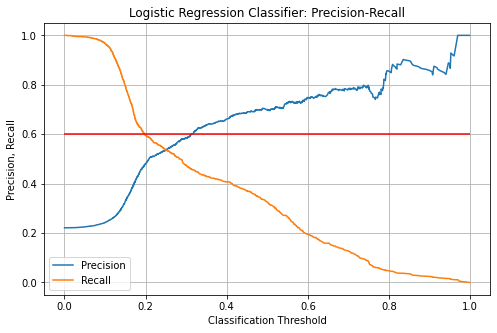

In [36]:
### Confusion Matrix with Modifier Logistic Regression Classifier

fig, ax= plt.subplots(figsize=(8, 5))
ax.plot(thresholds_lr, precision_lr[1:], label='Precision')
ax.plot(thresholds_lr, recall_lr[1:], label='Recall')
ax.set_xlabel('Classification Threshold')
ax.set_ylabel('Precision, Recall')
ax.set_title('Logistic Regression Classifier: Precision-Recall')
ax.hlines(y=0.6, xmin=0, xmax=1, color='red')
ax.legend()
ax.grid();

In [38]:
y_test_proba = logistic_reg.predict_proba(X_test)[:, 1]
y_pred_test = (y_test_proba >= 0.2).astype('int')

# Confusion Matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true= y_test)
print("Recall: ", 100*recall_score(y_pred = y_pred_test, y_true=y_test))
print("Precision: ", 100*precision_score(y_pred=y_pred_test, y_true=y_test))
CMatrix(CM)

Recall:  59.497487437185924
Precision:  47.85772029102668


PREDICTION,pay,default,Total
TRUE,,,
pay,2860,645,3505
default,403,592,995
Total,3263,1237,4500


## Making individual Predictions

In [42]:
def make_ind_predictions(new_data):
    data = new_data.values.reshape(-1, -1)
    data = robust_scaler.fit_transform(data)
    prob = logistic_reg.predict_proba(data)[0][1]
    if prob >=0.2:
        return 'Will default'
    else:
        return "Will pay"

In [43]:
pay = default[default['default']==0]
pay.head()

,limit_bal,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default,grad_school,university,high_school,male,married
ID,,,,,,,,,,,,,,,,,,,,,,,,,,
3,90000.0,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,0,1,0,0,0
4,50000.0,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,0,1,0,0,1
5,50000.0,57,0,0,0,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,0,1,0,1,1
6,50000.0,37,0,0,0,0,0,0,64400.0,57069.0,57608.0,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0,1,0,0,1,0
7,500000.0,29,0,0,0,0,0,0,367965.0,412023.0,445007.0,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,0,1,0,0,1,0
